<a href="https://colab.research.google.com/github/Geu-Pro2023/air_quality_forecasting/blob/main/Beijing_Air_Quality_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Air Quality Forecasting**
This is your first graded assignment for the Machine Learning Techniques I course. It focuses on applying Recurrent Neural Networks (RNNs) and Long Short-Term Memory (LSTM) models to solve a real-world problem: forecasting air pollution levels. Air pollution, particularly PM2.5, is a critical global issue that impacts public health and urban planning. By accurately predicting PM2.5 concentrations, governments and communities can take timely action to mitigate its effects.

This project aims to predict PM2.5 concentrations in Beijing using historical air quality and weather data. You will:

Preprocess sequential data to uncover patterns.
Design and train RNN or LSTM models to make accurate predictions.
Fine-tune the model and run several experiments. the goal is to be at the top of the leaderboard.

In [1]:
# Install the kaggle
!pip install -q kaggle

In [2]:
# upload the kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"geuagutogarang","key":"9a8a5492a098637e6155952d766ea4ad"}'}

In [3]:
# create a kaggle folder
!mkdir ~/.kaggle

In [4]:
# copy kaggle.json to the folder created
!cp kaggle.json ~/.kaggle/

In [5]:
#permision for the json to act
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# download the competition file
!kaggle competitions download -c assignment-1-time-series-forecasting-may-2025

  0% 0.00/839k [00:00<?, ?B/s]
100% 839k/839k [00:00<00:00, 964MB/s]


In [7]:
# Unzip the downloaded competition file
!unzip assignment-1-time-series-forecasting-may-2025.zip

Archive:  assignment-1-time-series-forecasting-may-2025.zip
  inflating: test.csv                
  inflating: train.csv               


# **Importing LIbraries**

In [38]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow. keras.layers import LSTM, Dense, Dropout, LayerNormalization, BatchNormalization
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [39]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
# Load the datasets
# Ensure train.csv and test.csv are saved in your Google Drive in the same folder.
# Replace the file paths below with the actual paths to your dataset.
train = pd.read_csv('/content/drive/MyDrive/Kaggle_competition/air_quality_forcasting_data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Kaggle_competition/air_quality_forcasting_data/test.csv')

# **Explore the training data**
In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

# **1. Dataset Overview**
The dataset consists of hourly air quality measurements recorded in Beijing.

The key features include meteorological factors (temperature, pressure, humidity, wind direction) and air pollution indicators (PM2.5 concentrations).

In [41]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [42]:
# Display basic statistics for the training dataset
print("\nTraining Data Statistics:")
train.describe()


Training Data Statistics:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
count,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,28755.000000
mean,15338.500000,-0.029431,-0.062712,0.013612,0.030542,0.016992,0.011253,0.016193,0.005833,-0.025008,100.793427
std,8855.542765,0.994087,1.015193,1.008991,1.018337,1.087278,1.063811,1.006001,1.001847,0.982122,93.144433
min,1.000000,-2.135153,-2.578070,-2.380821,-0.468688,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,0.000000
25%,7669.750000,-0.888034,-0.938521,-0.822670,-0.441894,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,29.000000
50%,15338.500000,-0.056622,0.045209,-0.043595,-0.352512,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,75.000000
75%,23007.250000,0.913358,0.864984,0.832865,0.005216,-0.069353,-0.137667,1.448138,1.366085,-0.522096,142.000000
max,30676.000000,1.814055,2.340578,2.877939,11.231956,35.439859,25.288745,1.448138,1.366085,1.915355,994.000000


In [43]:
# Display information about the training dataset, including data types and missing values
print("\nTraining Data Information:")
train.info()


Training Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30676 entries, 0 to 30675
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   No        30676 non-null  int64  
 1   DEWP      30676 non-null  float64
 2   TEMP      30676 non-null  float64
 3   PRES      30676 non-null  float64
 4   Iws       30676 non-null  float64
 5   Is        30676 non-null  float64
 6   Ir        30676 non-null  float64
 7   datetime  30676 non-null  object 
 8   cbwd_NW   30676 non-null  float64
 9   cbwd_SE   30676 non-null  float64
 10  cbwd_cv   30676 non-null  float64
 11  pm2.5     28755 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 2.8+ MB


# **1. Time Series Trend visualization for PM2.5:**

- The plot shows the trend of PM2.5 concentrations over time.
- PM2.5 refers to fine particulate matter in the air, which is a key indicator of air quality.

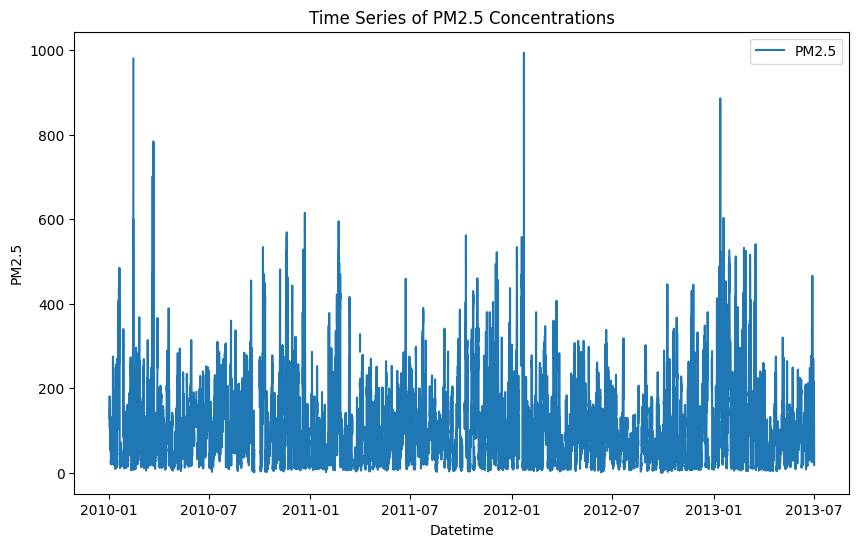

In [44]:
# Visualization: Time series trend for PM2.5
plt.figure(figsize=(10, 6))
plt.plot(pd.to_datetime(train['datetime']), train['pm2.5'], label='PM2.5')
plt.title('Time Series of PM2.5 Concentrations')
plt.xlabel('Datetime')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

# **Interpretation of the above Result.**
- High PM2.5 concentrations (e.g., values close to 1000) indicate poor air quality, which could be due to factors like industrial activity, vehicle emissions, or weather conditions.

- If the plot shows consistent spikes at certain times (e.g., winter months), it might suggest seasonal pollution sources, such as heating or reduced air dispersion.

In [49]:
# Display basic statistics for the test dataset
print("\nTest Data Statistics:")
test.describe()


Test Data Statistics:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv
count,13148.000000,13148.000000,13148.000000,13148.000000,13148.000000,13148.000000,13148.000000,13148.000000,13148.000000,13148.000000
mean,37250.500000,0.068667,0.146315,-0.031759,-0.071257,-0.039645,-0.026255,-0.037780,-0.013608,0.058346
std,3795.645004,1.010409,0.947697,0.978042,0.952125,0.756872,0.831803,0.984898,0.995621,1.038253
min,30677.000000,-2.897280,-2.086205,-2.478206,-0.468688,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096
25%,33963.750000,-0.749466,-0.692588,-0.920055,-0.441894,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096
50%,37250.500000,0.220515,0.209164,-0.043595,-0.388505,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096
75%,40537.250000,0.982643,0.946961,0.735481,-0.137955,-0.069353,-0.137667,1.448138,1.366085,-0.522096
max,43824.000000,1.675486,2.422555,2.196248,9.327940,30.179235,17.519564,1.448138,1.366085,1.915355


In [46]:
# Display information about the test dataset, including data types and missing values
print("\nTest Data Information:")
test.info()


Test Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13148 entries, 0 to 13147
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   No        13148 non-null  int64  
 1   DEWP      13148 non-null  float64
 2   TEMP      13148 non-null  float64
 3   PRES      13148 non-null  float64
 4   Iws       13148 non-null  float64
 5   Is        13148 non-null  float64
 6   Ir        13148 non-null  float64
 7   datetime  13148 non-null  object 
 8   cbwd_NW   13148 non-null  float64
 9   cbwd_SE   13148 non-null  float64
 10  cbwd_cv   13148 non-null  float64
dtypes: float64(9), int64(1), object(1)
memory usage: 1.1+ MB


In [47]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

# **2. Correlation Matrix of Features:**
- The correlation matrix shows the relationships (correlations) between different features in the dataset.

 Correlation values range from -1 to 1

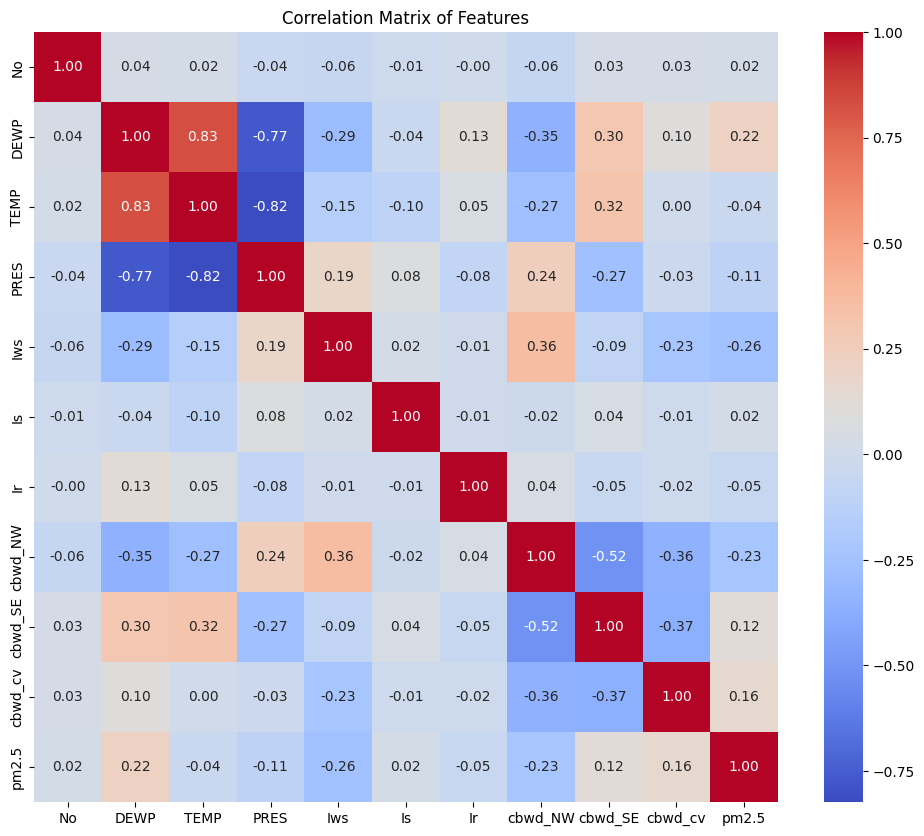

In [48]:
import seaborn as sns
import pandas as pd

plt.figure(figsize=(12, 10))
# Exclude non-numeric columns before calculating correlations
correlation_matrix = train.select_dtypes(include=['number']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

# **Interpretation of the Result**
- The strong negative correlation between DEWP and TEMP is expected, as dew point and temperature are inversely related in many climates.

- The weak correlations with pm2.5 suggest that other factors (not included in this matrix) might be more influential in determining PM2.5 levels, such as traffic, industrial activity, or geographic location.

# **3. Box Plot of Features to Identify Outliers**
- The box plot visualize the distribution of data for different features and identify potential outliers.
-  Outliers are data points that fall significantly outside the typical range of values.

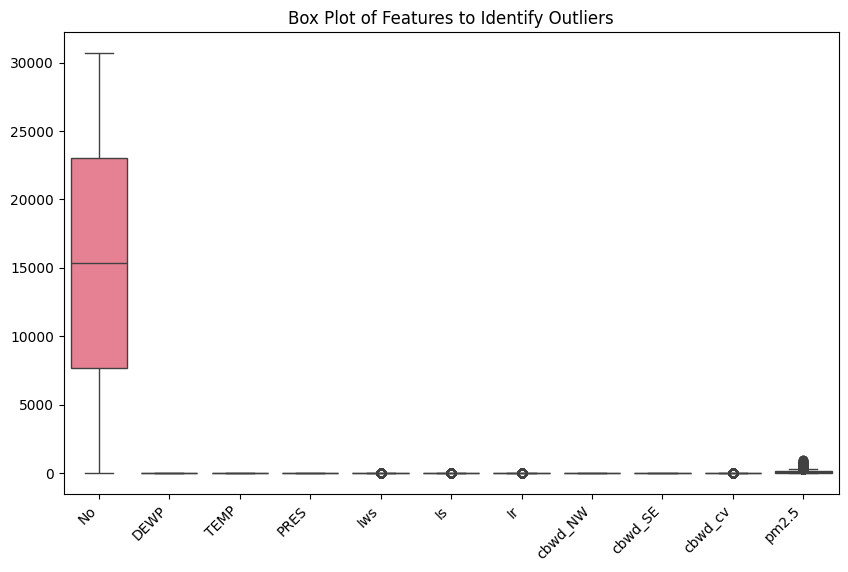

In [50]:
# Checking for outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=train)
plt.title('Box Plot of Features to Identify Outliers')
plt.xticks(rotation=45, ha='right')
plt.show()

# **Interpretation of the Result**
- If outliers are present, they could indicate errors in data collection, extreme events, or unique cases that deviate from the norm.

- For example, if pm2.5 has outliers with extremely high values, it could indicate days with severe air pollution due to specific events.

- Identifying outliers is important because they can skew analysis and modeling results, and may need to be addressed (e.g., removed or transformed).

In [51]:
# Checking for missing values
print("\nMissing values in training data:")
print(train.isnull().sum())


Missing values in training data:
No             0
DEWP           0
TEMP           0
PRES           0
Iws            0
Is             0
Ir             0
datetime       0
cbwd_NW        0
cbwd_SE        0
cbwd_cv        0
pm2.5       1921
dtype: int64


In [52]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)

# **Handle missing values**
- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

# **Checking for missing values**

In [53]:
# Check for missing values in the training data
print("\nMissing values in training data:")
print(train.isnull().sum())

# Check for missing values in the test data
print("\nMissing values in test data:")
print(test.isnull().sum())



Missing values in training data:
No            0
DEWP          0
TEMP          0
PRES          0
Iws           0
Is            0
Ir            0
cbwd_NW       0
cbwd_SE       0
cbwd_cv       0
pm2.5      1921
dtype: int64

Missing values in test data:
No         0
DEWP       0
TEMP       0
PRES       0
Iws        0
Is         0
Ir         0
cbwd_NW    0
cbwd_SE    0
cbwd_cv    0
dtype: int64


# **Filling the missing values with the means**

In [54]:
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)


# **Separate features and target**
- Feel free to drop any non-essential columns like that you think might not contribute to modeling.

In [55]:
X_train = train.drop(['pm2.5', 'No'], axis=1)
y_train = train['pm2.5']

In [56]:
# Reshape data for LSTM input
# LSTM models require data in the shape (samples, timesteps, features).
# Here, the data is reshaped to add a "timesteps" dimension.
X_train = np.expand_dims(X_train, axis=1)

# **Scaling the data**
- Ensures that features contribute equally to the analysis, especially in distance-based or gradient-based algorithms.
- Helps optimization algorithms like gradient descent converge faster.
- Makes model results easier to interpret, especially in regularized models.

In [57]:
from sklearn.preprocessing import MinMaxScaler

# Initializing the scaler
scaler = MinMaxScaler()

# Fitting the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1]))

# Reshaping the scaled data back to the original shape
X_train_scaled = X_train_scaled.reshape(X_train.shape)

# **Build model**
Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [58]:
# Define the LSTM model
# Experiment: L2 regularization, ReLU activation
# LSTM layer with L2 regularization
# Dropout layer for regularization
model_1 = Sequential()
model_1.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.01)))
model_1.add(Dropout(0.2))
model_1.add(LSTM(64, activation='relu', kernel_regularizer=l2(0.01)))
model_1.add(Dropout(0.2))
model_1.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model_1.add(Dense(1))

#Compile the model
model_1.compile(optimizer=Adam(learning_rate=0.01), loss='mse',
                metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))])

#Display model summary
model_1.summary()
history_1 = model_1.fit(X_train, y_train, epochs=20, batch_size=32)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 1, 128)         │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,177 (477.25 KB)

 Trainable params: 122,177 (477.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - lambda: 81.3344 - loss: 7118.4839
Epoch 2/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - lambda: 73.0841 - loss: 5699.0771
Epoch 3/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - lambda: 72.4053 - loss: 5627.0249
Epoch 4/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - lambda: 71.6725 - loss: 5468.8398
Epoch 5/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - lambda: 71.5688 - loss: 5463.4160
Epoch 6/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - lambda: 70.9526 - loss: 5362.8848
Epoch 7/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - lambda: 72.1521 - loss: 5558.3535
Epoch 8/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - lambda: 70.7039 - loss: 5321.6201
Epoch 9/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - lambda: 70.1176 - loss: 5227.3032
Epoch 10/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - lambda: 69.5182 - loss: 5137.6572
Epoch 11/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - lambda: 69.7785 - loss: 5168.8027
Epoch 12/20
959/959 ━━━━━

959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


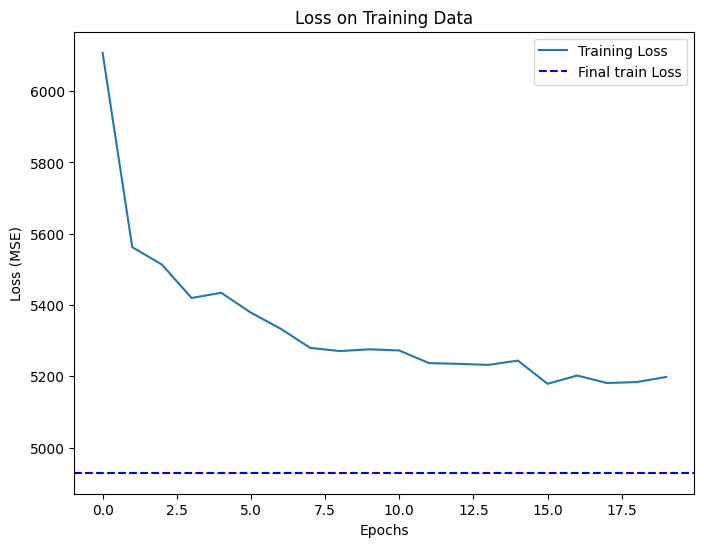

Final Training Loss (MSE): 4929.762291708849
Final Training Loss (RMSE): 70.21226596335464


In [59]:
# Calculate training loss
train_predictions = model_1.predict(X_train)
train_loss = np.mean((y_train - train_predictions.flatten())**2)
train_loss_RSME = np.sqrt(train_loss)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history_1.history['loss'], label='Training Loss')
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final train Loss')
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")
print(f"Final Training Loss (RMSE): {train_loss_RSME}")

In [61]:
# Prepare the test data
X_test = test.drop(['No'], axis=1)
X_test = np.expand_dims(X_test, axis=1)

# Make predictions on the test set using trained model to predict "pm2.5" concentrations
predictions = model_1.predict(X_test)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# Prepare the submission file
# Convert 'row ID' index to string and remove leading zeros for single-digit hours
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),  # Remove leading zeros for hours
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/content/drive/MyDrive/Kaggle_competition/air_quality_forcasting_data/subm_fixed.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [63]:
# Define the model
model_2 = Sequential()
model_2.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.001)))
model_2.add(Dropout(0.2))
model_2.add(LSTM(32, activation='relu', kernel_regularizer=l2(0.001)))  # Changed 'rel' to 'relu'
model_2.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model_2.add(Dense(1))

# Compile the model
model_2.compile(optimizer=Adam(learning_rate=0.0001),
                loss='mse',
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Train the model
history_2 = model_2.fit(X_train, y_train,
                         epochs=10, batch_size=32)

Epoch 1/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 17729.8809 - root_mean_squared_error: 133.1366
Epoch 2/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 9214.2324 - root_mean_squared_error: 95.9589
Epoch 3/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 7300.9800 - root_mean_squared_error: 85.4389
Epoch 4/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 6831.0244 - root_mean_squared_error: 82.6436
Epoch 5/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 6448.0703 - root_mean_squared_error: 80.2914
Epoch 6/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 6253.4243 - root_mean_squared_error: 79.0696
Epoch 7/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 6155.8105 - root_mean_squared_error: 78.4494
Epoch 8/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 5850.7632 - root_mean_squared_error: 76.4759
Epoch 9/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 5765.0874 - root_mean_squared_error: 75.9203
Epoch 10/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step 

959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


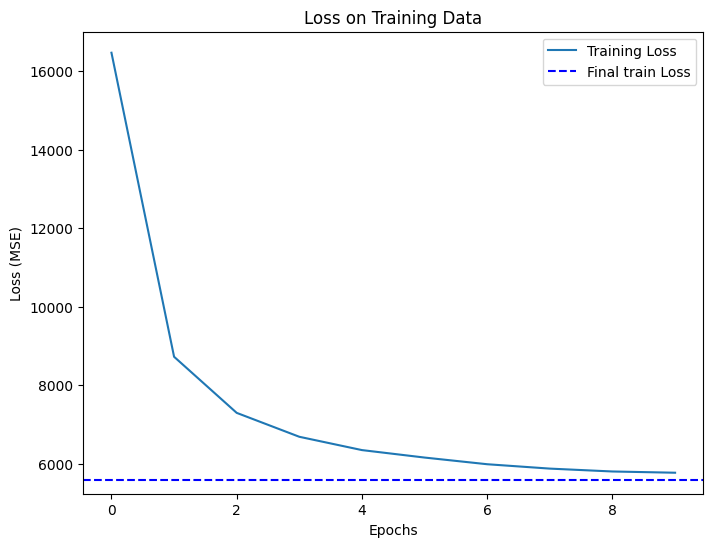

Final Training Loss (MSE): 5579.577590295951
Final Training Loss (RMSE): 74.69657013742967


In [64]:
# Calculate training loss
train_predictions = model_2.predict(X_train)
train_loss = np.mean((y_train - train_predictions.flatten())**2)
train_loss_RSME = np.sqrt(train_loss)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history_2.history['loss'], label='Training Loss')
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final train Loss')
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")
print(f"Final Training Loss (RMSE): {train_loss_RSME}")

In [68]:
# Prepare the test data
X_test = test.drop(['No'], axis=1)
X_test = np.expand_dims(X_test, axis=1)

# Make predictions on the test set using trained model to predict "pm2.5" concentrations
predictions = model_2.predict(X_test)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# Prepare the submission file
# Convert 'row ID' index to string and remove leading zeros for single-digit hours
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),  # Remove leading zeros for hours
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')
# Save the file in CSV format for submission on Kaggle
submission.to_csv('submission.csv', index=False)
!kaggle competitions submit -c assignment-1-time-series-forecasting-may-2025 -f submission.csv -m "model_LSTM"

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
100% 297k/297k [00:00<00:00, 878kB/s]
Successfully submitted to Assignment 1- Time Series Forecasting May 2025

## **Done!**
**Geu Aguto Garang**